In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, LSTM, BatchNorm1d, GRU
from torch.optim import Adam, lr_scheduler
import numpy as np
import random
from BaseNetwork import BaseNetwork

%load_ext autoreload
%autoreload 2

In [2]:
prev_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=prev_timesteps, 
                        max_future_time_steps=prediction_steps
                        )
validation = MoviaBusDataset('../data/validation', 
                       interpolation=True, 
                       prev_timesteps=prev_timesteps, 
                       max_future_time_steps=prediction_steps
                       )



In [10]:
#train.remove_trend()
#validation.remove_trend(train._historical_average)

In [3]:
train.normalize(individual_roads=False)
validation.normalize(train.mean, train.std)

In [53]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[1]

class EncDec(BaseNetwork):
    
    def __init__(self, hidden_size=100, num_layers=1):
        super().__init__(name="Sequence2Sequence")

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.encoder = GRU(num_roads, hidden_size, batch_first=True, num_layers=num_layers)
        
        self.decoder = GRU(num_roads, hidden_size, batch_first=True, num_layers=num_layers)
        self.activation = ReLU()
        self.decoder_l1 = Linear(hidden_size, num_roads)
        
    def forward(self, x_in):
        x = x_in['data']
        target = x_in['target']
        
        n_batch = x.size()[0]
        #torch.manual_seed(42)
        #hidden = (torch.randn(self.num_layers, n_batch, self.hidden_size),#.cuda(),
        #          torch.randn(self.num_layers, n_batch, self.hidden_size))#.cuda())
        hidden = torch.zeros(self.num_layers, n_batch, self.hidden_size)
        #Run previous timesteps through the encoder
        for t_i in range(prev_timesteps):
            _, hidden = self.encoder(x[:,t_i,:].view(-1,1,num_roads),hidden)
            
        
        #Use a GO symbol for the first input to the decoder
        x_t = torch.zeros(n_batch, 1, num_roads)
        
        use_teacher_forcing = True if random.random() < 0.5 and self.training else False
        predictions = []
        #Use the model to predict several timesteps into the future
        for t in range(prediction_steps):            
            #run through LSTM
            
            x_out, hidden = self.decoder(x_t.view(-1,1,num_roads),hidden)
            
            #apply activation and final outout layer
            x_out = self.decoder_l1((x_out))
                        
            prediction = x_out[:,0,:self.num_roads]
        
            predictions.append(prediction)
      
            #Use teacher forcing where we use the target at t to predict t+1
            if use_teacher_forcing:
                x_t = target[:,t,:]
            #Otherwise we use the prediction as the input 
            else:
                x_t = prediction
    
        return torch.stack(predictions,1)
    
    
net = EncDec()
optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=0)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

In [54]:
net.train_network(train, validation ,batch_size=batch_size, 
                  num_epochs=50,
                  optimizer_fun=optimizer_fun,
                  scheduler_fun=scheduler_fun,
                  criterion=criterion,
                  shuffle=True,
                 target_to_net=True)

epoch =  0  train loss = 0.472   validation loss = 0.468   output_std = 0.848
Model saved as Sequence2Sequence.pt
epoch =  2  train loss = 0.419   validation loss = 0.458   output_std = 0.863
Model saved as Sequence2Sequence.pt
epoch =  4  train loss = 0.413   validation loss = 0.455   output_std = 0.851
Model saved as Sequence2Sequence.pt
epoch =  6  train loss = 0.408   validation loss = 0.449   output_std = 0.887
Model saved as Sequence2Sequence.pt
epoch =  8  train loss = 0.405   validation loss = 0.457   output_std = 0.891
epoch = 10  train loss = 0.402   validation loss = 0.455   output_std = 0.863
epoch = 12  train loss = 0.396   validation loss = 0.456   output_std = 0.881
epoch = 14  train loss = 0.395   validation loss = 0.459   output_std = 0.872
epoch = 16  train loss = 0.394   validation loss = 0.457   output_std = 0.875
epoch = 18  train loss = 0.394   validation loss = 0.453   output_std = 0.872
epoch = 20  train loss = 0.393   validation loss = 0.455   output_std = 0.88

In [55]:
scores=[net.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[1.5141388177871704, 1.5177100896835327, 1.5194748640060425, 1.5245792865753174, 1.5281143188476562, 1.5358736515045166]
1.523315171400706


<IPython.core.display.Javascript object>


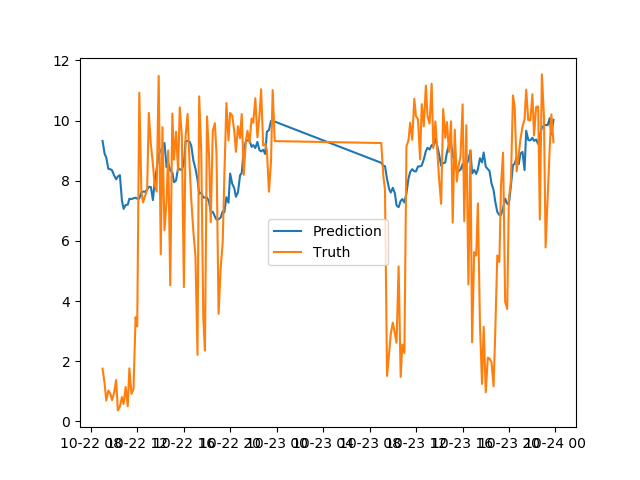

In [56]:
%matplotlib notebook

net.visualize_road(validation,timesteps=6, road=16)

* hidden = 100
* layers = 1
* no relu
* LSTM
* remove trend
* MAE = 
[1.5283441543579102, 1.532649278640747, 1.5375009775161743, 1.5411847829818726, 1.545353651046753, 1.5461335182189941]
1.5385277271270752


* hidden = 100
* layers = 1
* no relu
* LSTM
* normalize
* MAE = 
[1.5261757373809814, 1.539803147315979, 1.5530105829238892, 1.560333490371704, 1.5681395530700684, 1.5740176439285278]
1.5535800258318584